## Setup

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
datos_unidos = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datos_unidos.csv")

In [8]:
datos_unidos["DATE"] = pd.to_datetime(datos_unidos["DATE"])

In [9]:
datos_unidos.sort_values(by=["DATE", "STORE_ID", "SKU"], inplace=True)

## Ganancias a través del tiempo

Veamos la reducción de ganancia por día

In [10]:
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

In [11]:
# Calcular ganancia por fila
datos_unidos['GAIN'] = (datos_unidos['PRICE'] - datos_unidos['COSTOS']) * datos_unidos['QUANTITY']

gain_total = datos_unidos.groupby('DATE')['GAIN'].sum().reset_index()
gain_total["DATE"] = pd.to_datetime(gain_total["DATE"])

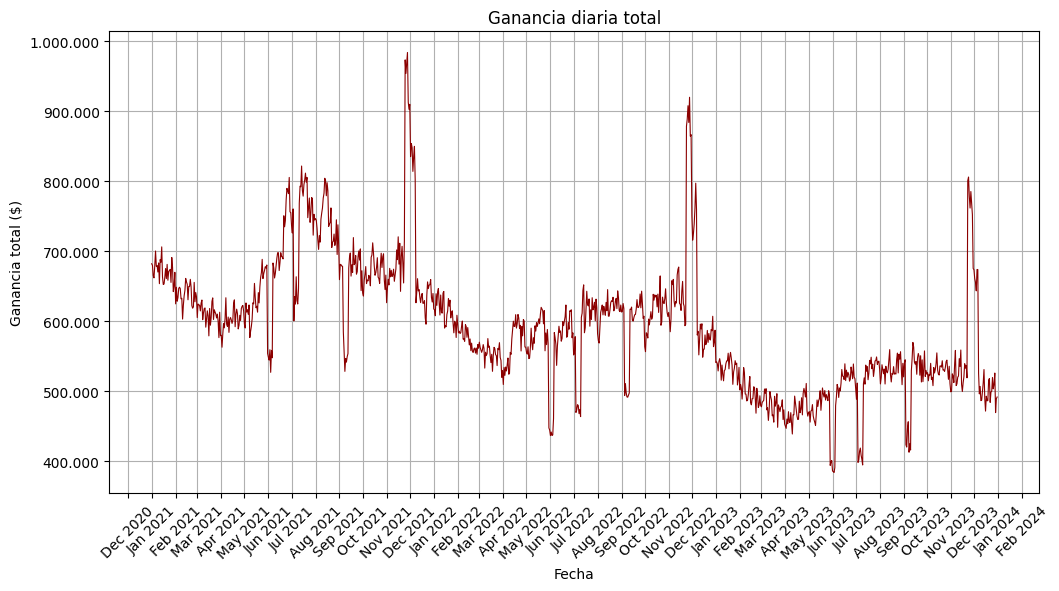

In [12]:
plt.figure(figsize=(12,6))
plt.plot(gain_total['DATE'], gain_total['GAIN'], color="darkred", linewidth=0.8)
plt.title('Ganancia diaria total')
plt.xlabel('Fecha')
plt.ylabel('Ganancia total ($)')
plt.grid(True)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())       # pone un tick por mes
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # formatea como 'Ene 2025'
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'.replace(',', '.')))

plt.xticks(rotation=45)
plt.show()

En el panorama global, vemos una caída gradual de las ganancias conforme pasan los años.

A nivel año, las ganancias en general suben a medida que pasa el año y descienden a principios de cada año.

Además, vemos que en Mayo, Junio y Agosto hay caídas abruptas de las ganancias, como también hay subidas abruptas en diciembre.

In [13]:
# Veamos las pérdidas de cada año en porcentaje
gain_total["YEAR"] = gain_total["DATE"].dt.year
gain_total.groupby(by="YEAR")["GAIN"].sum()

,GAIN
YEAR,
2021,2.454686e+08
2022,2.177372e+08
2023,1.871870e+08


In [14]:
perdida_2y = round((216750585.87-244378830.55)/216750585.87 * 100, 2)
perdida_3y = round((186420480.41 - 216750585.87)/ 216750585.87 * 100, 2)

In [15]:
print(f"Perdida en 2do año: {perdida_2y}%")
print(f"Perdida en 3er año: {perdida_3y}%")

Perdida en 2do año: -12.75%
Perdida en 3er año: -13.99%


## Demanda

In [16]:
datos_unidos["CATEGORY"].unique()

array(['Beauty', 'Books', 'Clothing', 'Electronics', 'Groceries',
       'Home & Kitchen', 'Sports', 'Toys'], dtype=object)

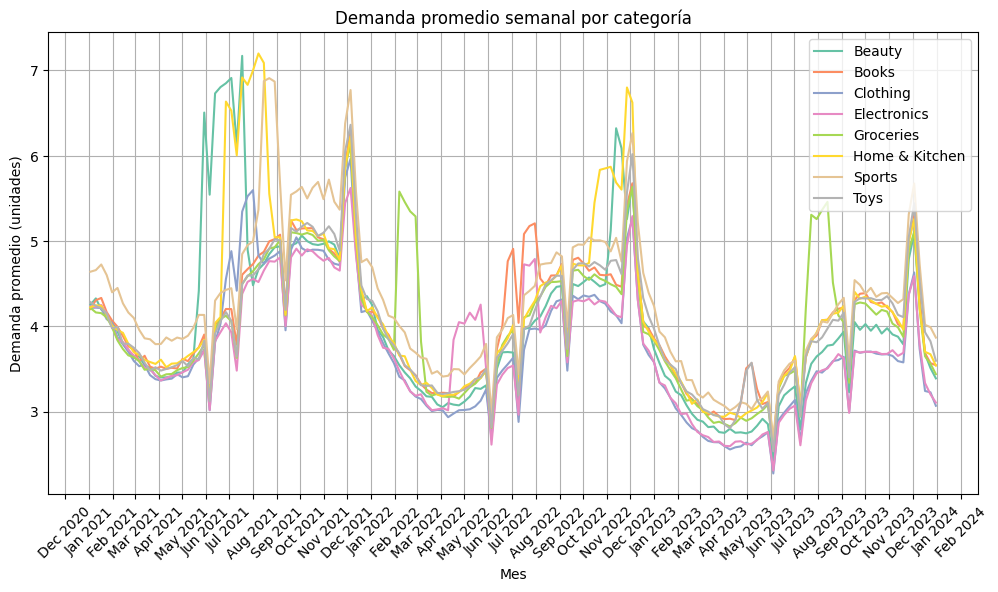

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Agrupar por mes, SKU y STORE_ID
df_monthly = (
    datos_unidos.groupby([pd.Grouper(key="DATE", freq="W"), "CATEGORY"])["QUANTITY"]
    .mean()
    .reset_index()
)

# Graficar
plt.figure(figsize=(12, 6))

# 8 colores bien diferenciados
category_colors = {
    cat: color
    for cat, color in zip(df_monthly["CATEGORY"].unique(), plt.cm.Set2.colors[:8])
}

for category, sub_df in df_monthly.groupby("CATEGORY"):
    plt.plot(sub_df["DATE"], sub_df["QUANTITY"], label=category, color=category_colors[category])

plt.xlabel("Mes")
plt.ylabel("Demanda promedio (unidades)")
plt.title("Demanda promedio semanal por categoría")
plt.legend(loc="upper right")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


Vemos un comportamiento muy parecido al gráfico de las ganancias

In [18]:
# Veamos como cambia en porcentaje la demanda por año
demanda_total = datos_unidos.groupby("YEAR")["QUANTITY"].sum()
demanda_2y = (demanda_total[2022]- demanda_total[2021]) / demanda_total[2021] *100
demanda_3y = (demanda_total[2023]- demanda_total[2022]) / demanda_total[2022] *100

In [19]:
print(f"Demanda en 2do año: {demanda_2y.round(2)}%" )
print(f"Demanda en 3er: {demanda_3y.round(2)}%" )

Demanda en 2do año: -9.99%
Demanda en 3er: -12.53%


Es decir, las pérdidas de ganancias no se deben solamente a la bajada de demanda.

## Precios

Ahora veremos cómo cambian los precios de todos los productos, promediando sus cambios en porcentaje

In [20]:
# Calcular precio inicial por SKU
datos_unidos['PRICE_FIRST'] = datos_unidos.groupby('SKU')['PRICE'].transform('first')

# Calcular cambio porcentual relativo al primer precio
datos_unidos['PRICE_CHANGE_PCT'] = (datos_unidos['PRICE'] / datos_unidos['PRICE_FIRST'] - 1) * 100

# Resumir por fecha
df_price_change = datos_unidos.groupby(['DATE'])['PRICE_CHANGE_PCT'].mean().reset_index()

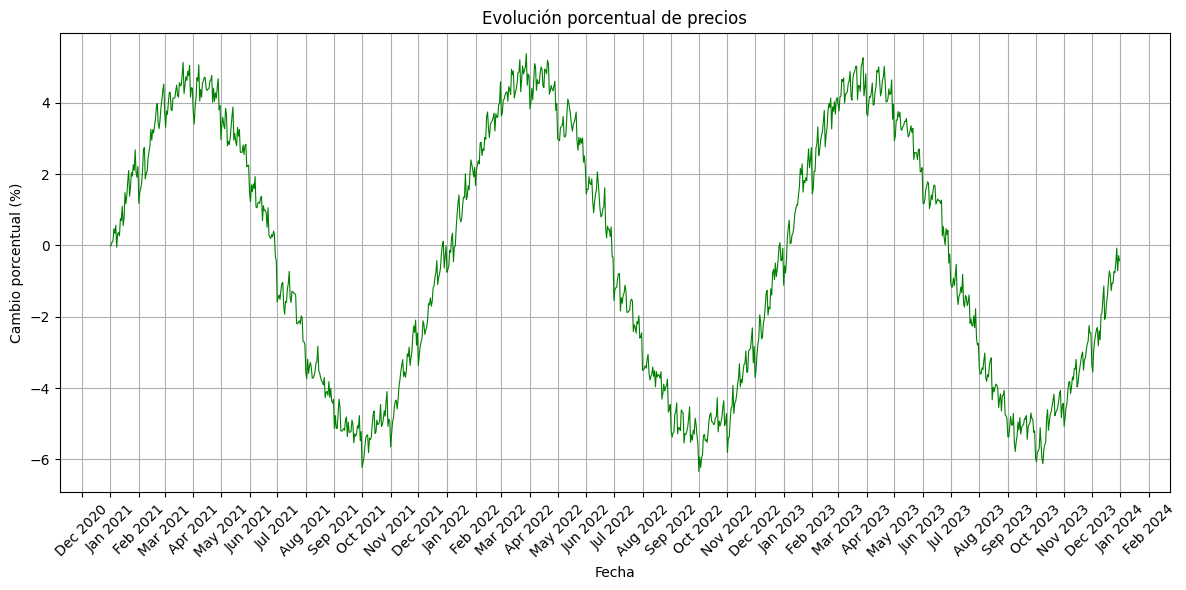

In [21]:
# Graficar
plt.figure(figsize=(12,6))

plt.plot(df_price_change[['DATE']], df_price_change['PRICE_CHANGE_PCT'], linewidth=0.8, color="green")

plt.title('Evolución porcentual de precios')
plt.xlabel('Fecha')
plt.ylabel('Cambio porcentual (%)')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

Se puede observar que los precios tienen una relación inversa con las ganancias y la demanda: alrededor de mitad de año, cuando la demanda es baja, los precios son más altos, y a finales, cuando hay demanda alta, se realizan descuentos.

## Elasticidad

/tmp/ipython-input-797789431.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title=f'Elasticidad ≈ {elasticity:.2f}')


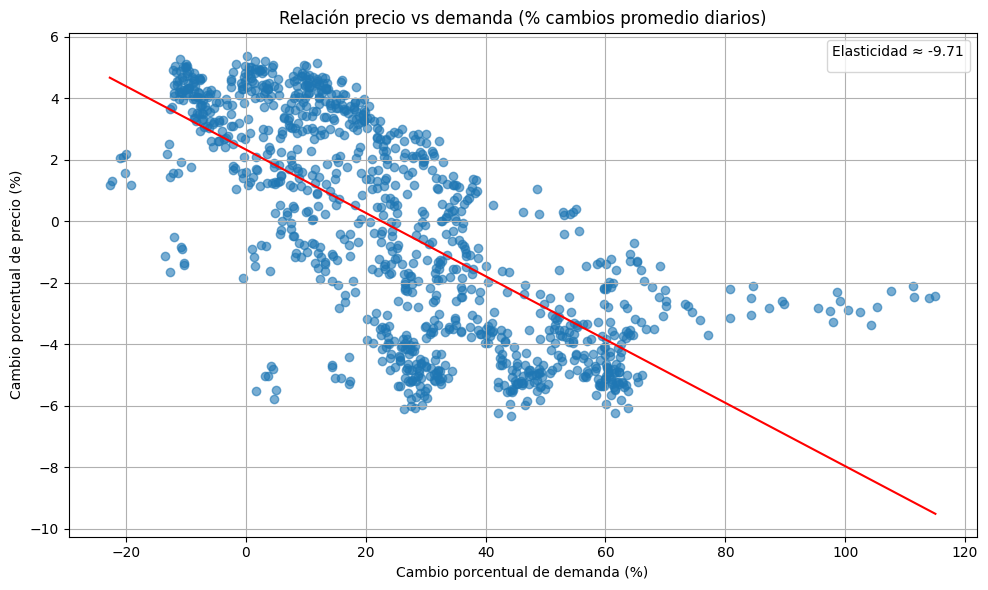

Pendiente (precio vs demanda): -0.103
Elasticidad-precio estimada: -9.706


In [32]:
# Cambio porcentual en precio
datos_unidos['PRICE_FIRST'] = datos_unidos.groupby('SKU')['PRICE'].transform('first')
datos_unidos = datos_unidos[datos_unidos['PRICE_FIRST'].notna()]
datos_unidos['PRICE_PCT'] = (datos_unidos['PRICE'] / datos_unidos['PRICE_FIRST'] - 1) * 100

# Cambio porcentual en demanda
qty_col = 'QUANTITY' if 'QUANTITY' in datos_unidos.columns else 'QUANTITIY'
datos_unidos['DEMAND_FIRST'] = datos_unidos.groupby('SKU')[qty_col].transform('first')
datos_unidos = datos_unidos[datos_unidos['DEMAND_FIRST'].notna()]
datos_unidos['DEMAND_PCT'] = (datos_unidos[qty_col] / datos_unidos['DEMAND_FIRST'] - 1) * 100

# Promedio diario
daily = datos_unidos.groupby('DATE').agg(
    PRICE_PCT=('PRICE_PCT','mean'),
    DEMAND_PCT=('DEMAND_PCT','mean')
).reset_index()

# Scatter
x = daily['DEMAND_PCT'].values
y = daily['PRICE_PCT'].values

fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(x, y, alpha=0.6)
ax.set_xlabel('Cambio porcentual de demanda (%)')
ax.set_ylabel('Cambio porcentual de precio (%)')
ax.grid(True)

# Ajuste de recta y cálculo de elasticidad
mask = np.isfinite(x) & np.isfinite(y)
if mask.sum() >= 2:
    # Pendiente de Y sobre X
    slope, intercept = np.polyfit(x[mask], y[mask], 1)
    # Recta de ajuste
    x_line = np.linspace(np.min(x[mask]), np.max(x[mask]), 100)
    y_line = slope * x_line + intercept
    ax.plot(x_line, y_line, color='red')

    # Elasticidad = 1 / pendiente
    if slope != 0:
        elasticity = 1 / slope
    else:
        elasticity = np.nan
    ax.legend(title=f'Elasticidad ≈ {elasticity:.2f}')

plt.title('Relación precio vs demanda (% cambios promedio diarios)')
plt.tight_layout()
plt.show()

print(f'Elasticidad-precio estimada: {elasticity:.3f}')


Esto quiere decir que, en promedio, un cambio del 1% en los precios produce un 10% de decrecimiento en la demanda, es decir, hay una gran elasticidad y pequeños cambios en los precios pueden afectar mucho la demanda, y por lo tanto, las ganancias.

## Ganancias por categoria

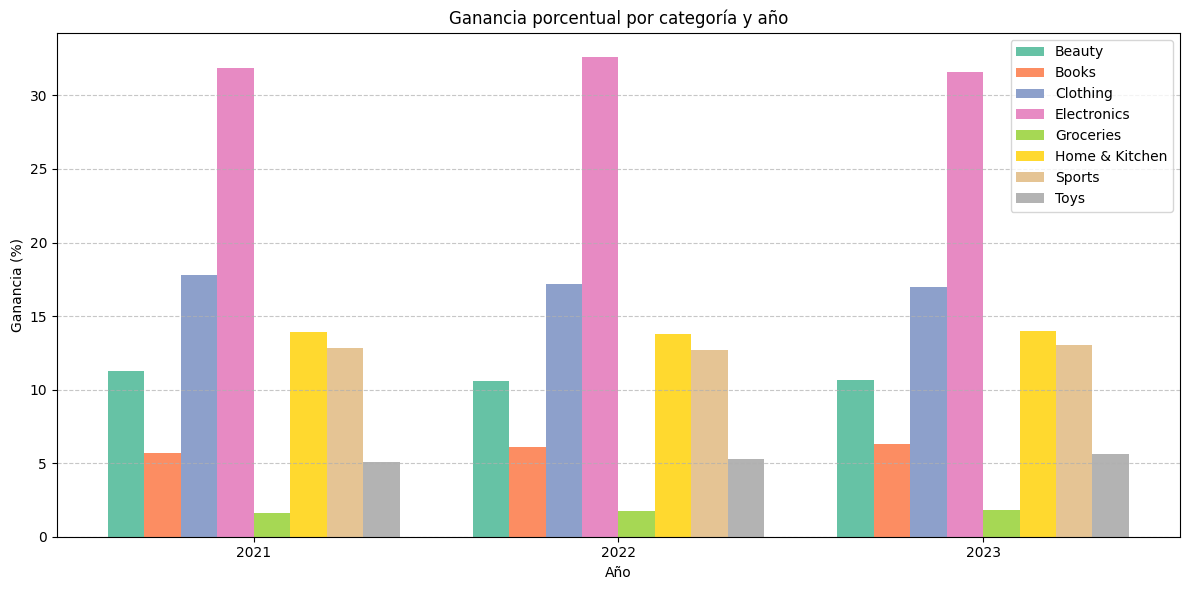

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Asegurarse que DATE es datetime
datos_unidos['DATE'] = pd.to_datetime(datos_unidos['DATE'])
datos_unidos['YEAR'] = datos_unidos['DATE'].dt.year

# Sumar ganancia por año y categoría
ganancia_cat = datos_unidos.groupby(['YEAR', 'CATEGORY'])['GAIN'].sum().reset_index()

# Calcular porcentaje sobre el total del año
total_year = ganancia_cat.groupby('YEAR')['GAIN'].transform('sum')
ganancia_cat['GAIN_PCT'] = ganancia_cat['GAIN'] / total_year * 100

# --- Gráfico de barras con separación mayor ---
years = sorted(ganancia_cat['YEAR'].unique())
categories = ganancia_cat['CATEGORY'].unique()
bar_width = 0.15
group_spacing = 1.5  # factor de separación entre años
x = np.arange(len(years)) * group_spacing

fig, ax = plt.subplots(figsize=(12,6))

for i, cat in enumerate(categories):
    y = []
    for year in years:
        val = ganancia_cat[(ganancia_cat['YEAR']==year) & (ganancia_cat['CATEGORY']==cat)]['GAIN_PCT']
        y.append(val.values[0] if len(val) > 0 else 0)
    ax.bar(x + i*bar_width, y, width=bar_width, label=cat, color = category_colors[cat])

ax.set_xlabel('Año')
ax.set_ylabel('Ganancia (%)')
ax.set_title('Ganancia porcentual por categoría y año')
ax.set_xticks(x + bar_width*(len(categories)-1)/2)
ax.set_xticklabels(years)
ax.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## Ganancias por región

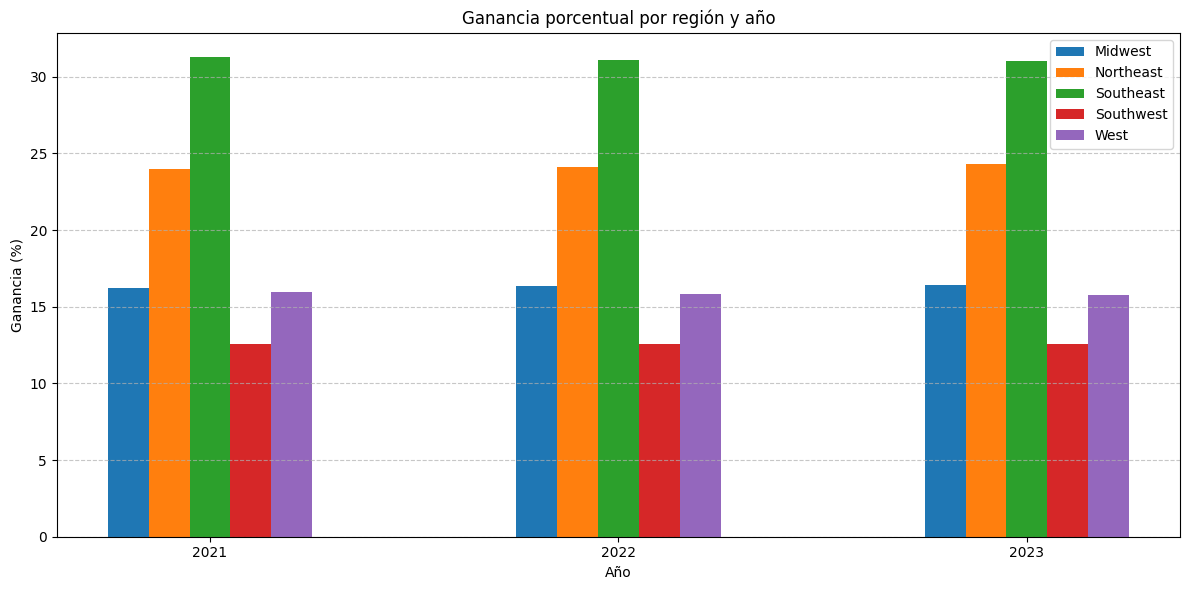

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Asegurarse que DATE es datetime
datos_unidos['DATE'] = pd.to_datetime(datos_unidos['DATE'])
datos_unidos['YEAR'] = datos_unidos['DATE'].dt.year

# Sumar ganancia por año y región
ganancia_region = datos_unidos.groupby(['YEAR', 'REGION'])['GAIN'].sum().reset_index()

# Calcular porcentaje sobre el total del año
total_year = ganancia_region.groupby('YEAR')['GAIN'].transform('sum')
ganancia_region['GAIN_PCT'] = ganancia_region['GAIN'] / total_year * 100

# --- Gráfico de barras con separación mayor ---
years = sorted(ganancia_region['YEAR'].unique())
regions = ganancia_region['REGION'].unique()
bar_width = 0.15
group_spacing = 1.5  # separación entre años
x = np.arange(len(years)) * group_spacing

fig, ax = plt.subplots(figsize=(12,6))

for i, reg in enumerate(regions):
    y = []
    for year in years:
        val = ganancia_region[(ganancia_region['YEAR']==year) & (ganancia_region['REGION']==reg)]['GAIN_PCT']
        y.append(val.values[0] if len(val) > 0 else 0)
    ax.bar(x + i*bar_width, y, width=bar_width, label=reg)

ax.set_xlabel('Año')
ax.set_ylabel('Ganancia (%)')
ax.set_title('Ganancia porcentual por región y año')
ax.set_xticks(x + bar_width*(len(regions)-1)/2)
ax.set_xticklabels(years)
ax.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
